<a href="https://colab.research.google.com/github/eaderogba/MP_Detection_ML/blob/main/classification_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization,Activation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your Train and Test directory
train_dir = '/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/cell_images'
test_dir = '/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/Malaria parasite images-20240820T153559Z-001/Malaria parasite images/Test'

In [ ]:
# Specify parameters for batch size, image height and width
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
# Image data generator for loading and processing images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load training and validation datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [ ]:
print(f"Number of training samples: {train_generator.n}")
print(f"Number of validation samples: {val_generator.n}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Number of training samples: 22048
Number of validation samples: 5510
Number of classes: 2
Class indices: {'Parasitized': 0, 'Uninfected': 1}


In [ ]:
def create_model():
  model = Sequential([
      # First Convolutional Block
      Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D(2, 2),
      Dropout(0.2),

      # Second Convolutional Block
      Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D(2, 2),
      Dropout(0.2),

      # Third Convolutional Block
      Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D(2, 2),
      Dropout(0.2),

      # Fourth Convolutional Block
      Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D(2, 2),
      Dropout(0.2),

      # Dense layers
      Flatten(),
      Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=Adam(learning_rate=0.0002),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
# Create the model
model = create_model()

model.build(input_shape=(None, img_height, img_width, 3))

# Display model summary
model.summary()

/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,921 (2.75 MB)

 Trainable params: 721,089 (2.75 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - accuracy: 0.5971 - loss: 1.2923 - val_accuracy: 0.7579 - val_loss: 1.1362 - learning_rate: 2.0000e-04
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 672s 974ms/step - accuracy: 0.8318 - loss: 0.8183 - val_accuracy: 0.8762 - val_loss: 0.7350 - learning_rate: 2.0000e-04
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 717s 1s/step - accuracy: 0.8825 - loss: 0.6945 - val_accuracy: 0.8780 - val_loss: 0.7412 - learning_rate: 2.0000e-04
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 668s 968ms/step - accuracy: 0.8985 - loss: 0.6255 - val_accuracy: 0.8181 - val_loss: 0.7622 - learning_rate: 2.0000e-04
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 663s 941ms/step - accuracy: 0.9101 - loss: 0.5736 - val_accuracy: 0.9093 - val_loss: 0.5561 - learning_rate: 2.0000e-04
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 649s 940ms/step - accuracy: 0.9073 - loss: 0.5347 - val_accuracy: 0.9040 - val_loss: 0.6066 - learning_rate: 2.0000e-04
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 650s 942ms/step -

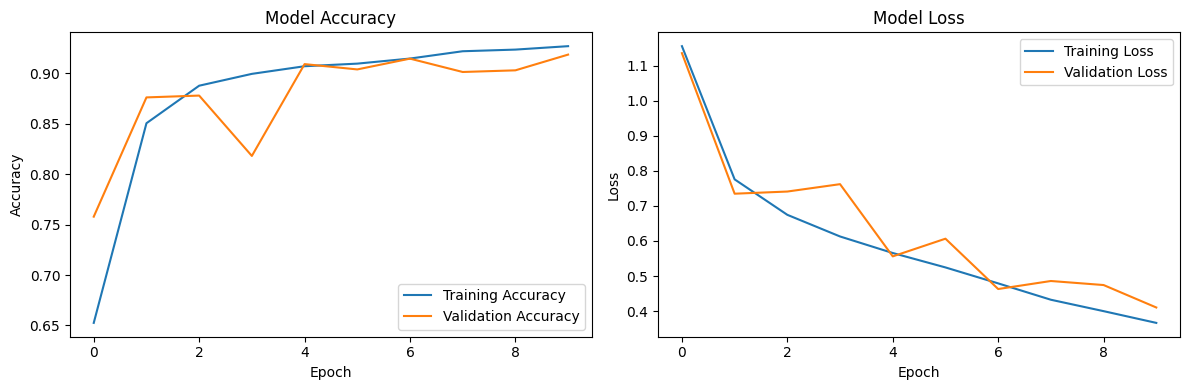

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Normalise test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'binary',
    shuffle = False
)

# Make predictions on test dataset
predictions = model.predict(test_generator)

# Make predictions to binary classes
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels from the generator
true_labels = test_generator.classes

# Print the results
for i in range(len(predicted_classes)):
    print(f"Image: {test_generator.filenames[i]}, Predicted: {'Infected' if predicted_classes[i] == 1 else 'Uninfected'}, True: {'Infected' if true_labels[i] == 1 else 'Unifected'}")

    print(classification_report(true_labels, predicted_classes, target_names=test_generator.class_indices.keys()))

Found 134 images belonging to 2 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Image: Parasite/C39P4thinF_original_IMG_20150622_105554_cell_10.png, Predicted: Uninfected, True: Unifected
              precision    recall  f1-score   support

    Parasite       1.00      0.90      0.95        91
  Uninfected       0.83      1.00      0.91        43

    accuracy                           0.93       134
   macro avg       0.91      0.95      0.93       134
weighted avg       0.94      0.93      0.93       134

Image: Parasite/C39P4thinF_original_IMG_20150622_105554_cell_11.png, Predicted: Uninfected, True: Unifected
              precision    recall  f1-score   support

    Parasite       1.00      0.90      0.95        91
  Uninfected       0.83      1.00      0.91        43

    accuracy                           0.93       134
   macro avg       0.91      0.95      0.93       134
weighted avg       0.94      0.93      0.93       134

Image: Parasite/C39P4thinF_original_IMG_20150622_1

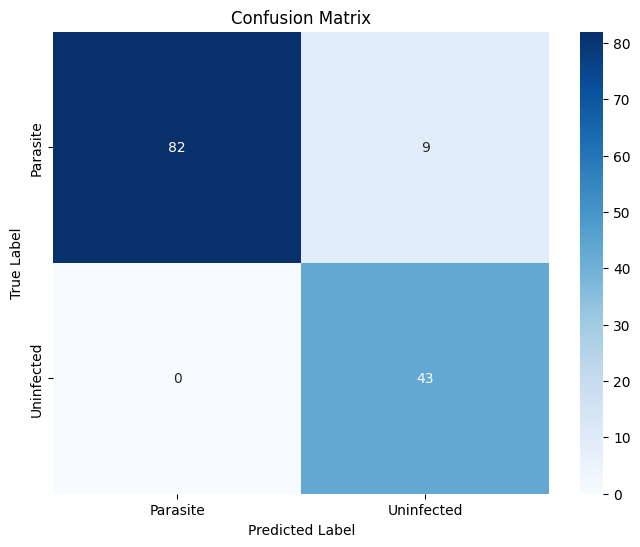

In [ ]:
# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(
), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()